# Predviđanje popularnosti online članaka

### Jovan Jurić 1206

Zadatak ovog projekta je predviđanje popularnosti online članaka. Dataset je preuzet sa ovog __[linka](http://archive.ics.uci.edu/ml/datasets/Online+News+Popularity)__.

In [1]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split
import seaborn as sb
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
#Read data
data = pd.read_csv('./dataset.csv',sep=',',skipinitialspace=True)
data = data.sample(frac = 1)
data

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
14246,http://mashable.com/2013/10/09/apple-ipad-5-le...,456.0,10.0,1435.0,0.390157,1.0,0.572804,16.0,7.0,8.0,...,0.050000,1.0,-0.229365,-1.000000,-0.050000,0.000000,0.000000,0.500000,0.000000,1900
37697,http://mashable.com/2014/11/25/moto-hint-review/,42.0,10.0,460.0,0.479029,1.0,0.580420,2.0,1.0,3.0,...,0.050000,0.5,-0.313750,-0.600000,-0.100000,0.900000,-0.600000,0.400000,0.600000,1200
38826,http://mashable.com/2014/12/12/new-york-city-s...,24.0,14.0,639.0,0.514107,1.0,0.743662,6.0,4.0,1.0,...,0.100000,1.0,-0.382630,-1.000000,-0.071429,0.638889,0.116667,0.138889,0.116667,995
22600,http://mashable.com/2014/03/29/culture-of-empo...,285.0,13.0,444.0,0.619617,1.0,0.787546,16.0,2.0,1.0,...,0.100000,0.8,-0.348810,-1.000000,-0.050000,0.150000,0.100000,0.350000,0.100000,2900
15984,http://mashable.com/2013/11/12/itunes-donate-t...,422.0,6.0,140.0,0.724638,1.0,0.842697,2.0,0.0,1.0,...,0.200000,1.0,-0.312500,-0.800000,-0.187500,0.000000,0.000000,0.500000,0.000000,998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27639,http://mashable.com/2014/06/24/luis-suarez-bit...,198.0,11.0,219.0,0.557078,1.0,0.697674,5.0,2.0,2.0,...,0.100000,0.8,-0.125000,-0.125000,-0.125000,0.477273,0.318182,0.022727,0.318182,701
24578,http://mashable.com/2014/05/02/must-reads-5-2-14/,251.0,10.0,315.0,0.590476,1.0,0.753846,11.0,5.0,1.0,...,0.033333,0.5,-0.141667,-0.166667,-0.125000,0.000000,0.000000,0.500000,0.000000,905
33792,http://mashable.com/2014/10/01/advertising-wee...,99.0,14.0,990.0,0.451481,1.0,0.611475,11.0,2.0,1.0,...,0.100000,1.0,-0.208333,-0.800000,-0.075000,0.562626,0.328788,0.062626,0.328788,2700
3440,http://mashable.com/2013/03/07/zombie-shuffle/,672.0,10.0,538.0,0.538899,1.0,0.726962,4.0,2.0,0.0,...,0.100000,0.6,-0.289297,-0.400000,-0.100000,0.400000,-0.150000,0.100000,0.150000,2100


Svako preprocesiranje dataseta je izvršeno pre njegovog objavljivanja tako da ne postoje nikakve nevalidne odnosno prazne vrednosti. 

Možemo uočiti da su nam podaci iz prve dve kolone (URL i broj dana koji je protekao između objavljivanja članaka i preuzimanja podataka) beznačajne za predviđanje naših podataka tako da ćemo ih odmah izbaciti iz upotrebe.

Što znači da imamo 58 atributa za predviđanje i jednu ciljnu vrednost (broj share-ova) kao i gotovo 40.000 entiteta.

In [3]:
x = data.iloc[:,2:-1]
column_names = x.columns
y = data['shares']

U nastavku je data deskriptivna analiza podataka ulaznih podataka.

In [4]:
x.describe()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,10.398749,546.514731,0.548216,0.996469,0.689175,10.883690,3.293638,4.544143,1.249874,4.548239,...,0.353825,0.095446,0.756728,-0.259524,-0.521944,-0.107500,0.282353,0.071425,0.341843,0.156064
std,2.114037,471.107508,3.520708,5.231231,3.264816,11.332017,3.855141,8.309434,4.107855,0.844406,...,0.104542,0.071315,0.247786,0.127726,0.290290,0.095373,0.324247,0.265450,0.188791,0.226294
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000
25%,9.000000,246.000000,0.470870,1.000000,0.625739,4.000000,1.000000,1.000000,0.000000,4.478404,...,0.306244,0.050000,0.600000,-0.328383,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000
50%,10.000000,409.000000,0.539226,1.000000,0.690476,8.000000,3.000000,1.000000,0.000000,4.664082,...,0.358755,0.100000,0.800000,-0.253333,-0.500000,-0.100000,0.150000,0.000000,0.500000,0.000000
75%,12.000000,716.000000,0.608696,1.000000,0.754630,14.000000,4.000000,4.000000,1.000000,4.854839,...,0.411428,0.100000,1.000000,-0.186905,-0.300000,-0.050000,0.500000,0.150000,0.500000,0.250000
max,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,116.000000,128.000000,91.000000,8.041534,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000


Zatim vršimo i analizu share-ova.

In [5]:
y.describe()

count     39644.000000
mean       3395.380184
std       11626.950749
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name: shares, dtype: float64

Naredni graf nam prikazuje distribuciju share-ova.

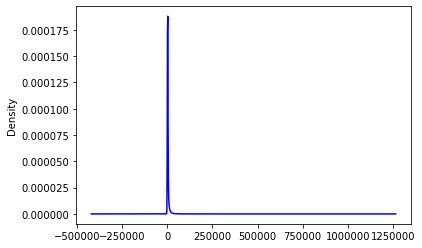

In [6]:
data['shares'].plot(kind='kde', color='blue')

Pošto imamo podatke gde svaki atribut ima različiti opseg vrednosti potrebno je izvršiti skaliranje podataka po kolonama kako bi svi podaci bili pozitivni i u opsegu <bold>[0,1]</bold>.

In [7]:
for column in x.columns:
    min_max_scaler = MinMaxScaler()
    x[column] = min_max_scaler.fit_transform(x[column].values.reshape(-1,1))

Pošto želimo da vršimo klasifikaciju o tome da li će članak biti popularan ili ne tu pretpostavku ćemo izvršiti tako što ćemo obeležiti sve članke koji imaju više od 1400 share-ova kao popularne. Takođe ćemo podatke prebaciti u tip np.array.

In [8]:
x = np.array(x)
y = np.array([i > 1400 for i in y])

Zatim delimo podatke na skupove za treniranje i testiranje. 

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1, train_size=0.8)

In [10]:
gnb = GaussianNB()
dt = DecisionTreeClassifier()
svc = SVC()
knn = KNeighborsClassifier(n_neighbors=20)
rand_forest = RandomForestClassifier(max_depth=50,random_state=5,n_estimators=200)

In [11]:
#Ova metoda prikazuje najbitnije fičure kod modela
def plot_feature_importance(model):
    plt.title('Feature importance')   
    column_names_top_10 = [item for _,item in sorted(zip(model.feature_importances_[1:],column_names),reverse=True)]
    column_names_top_10 = column_names_top_10[:10]
    feature_importance_top_10 = sorted(model.feature_importances_[:-1],reverse=True)[:10]
    plt.barh(column_names_top_10, feature_importance_top_10)
    plt.show()
    
#Ova metoda služi za treniranje modela i prikazivanje rezultata testiranja
def run_model(model,print_feature_importance=False):
    print('*'*75)
    print('Model class:',type(model))
    trained_model = model.fit(x_train,y_train)
    print('Model test score:',trained_model.score(x_test,y_test))
    pred = trained_model.predict(x_test)
    cross_val_results = cross_val_score(model,x,y)
    print('Cross validation results (5 fold):',cross_val_results)
    print(classification_report(y_test,pred))
    cm = confusion_matrix(y_test,pred)
    cm_df = pd.DataFrame(cm,[0,1],[0,1])
    group_names=['TN','FP','FN','TP']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.title('Confusion matrix heatmap')
    sb.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.show()
    print('*'*75)

***************************************************************************
Model class: <class 'sklearn.naive_bayes.GaussianNB'>
Model test score: 0.6075167108084247
Cross validation results (5 fold): [0.6061294  0.53184513 0.53512423 0.53121453 0.53165994]
              precision    recall  f1-score   support

       False       0.58      0.77      0.67      3990
        True       0.66      0.44      0.53      3939

    accuracy                           0.61      7929
   macro avg       0.62      0.61      0.60      7929
weighted avg       0.62      0.61      0.60      7929



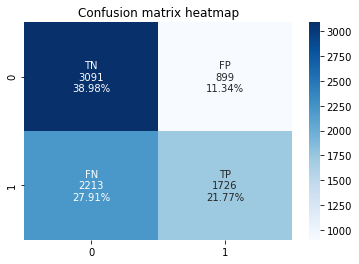

***************************************************************************


In [12]:
run_model(gnb)

***************************************************************************
Model class: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Model test score: 0.5786353890780679
Cross validation results (5 fold): [0.56425779 0.58128389 0.57964434 0.57031151 0.57605954]
              precision    recall  f1-score   support

       False       0.58      0.59      0.58      3990
        True       0.58      0.57      0.57      3939

    accuracy                           0.58      7929
   macro avg       0.58      0.58      0.58      7929
weighted avg       0.58      0.58      0.58      7929



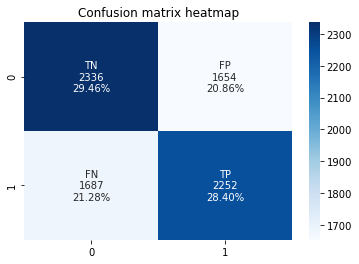

***************************************************************************


In [13]:
run_model(dt)

***************************************************************************
Model class: <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Model test score: 0.6293353512422752
Cross validation results (5 fold): [0.61281372 0.61874133 0.62202043 0.61836297 0.62600908]
              precision    recall  f1-score   support

       False       0.61      0.72      0.66      3990
        True       0.65      0.54      0.59      3939

    accuracy                           0.63      7929
   macro avg       0.63      0.63      0.63      7929
weighted avg       0.63      0.63      0.63      7929



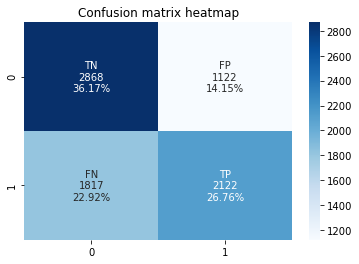

***************************************************************************


In [14]:
run_model(knn)

***************************************************************************
Model class: <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>
Model test score: 0.6636398032538782
Cross validation results (5 fold): [0.65758608 0.66162189 0.66263085 0.66401816 0.65956105]
              precision    recall  f1-score   support

       False       0.66      0.68      0.67      3990
        True       0.67      0.65      0.66      3939

    accuracy                           0.66      7929
   macro avg       0.66      0.66      0.66      7929
weighted avg       0.66      0.66      0.66      7929



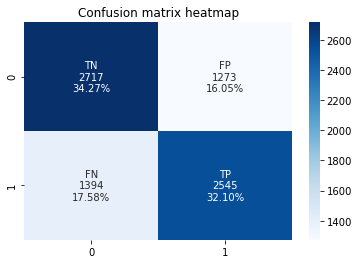

***************************************************************************


In [17]:
ada = AdaBoostClassifier(n_estimators=100, random_state=0)
run_model(ada)

***************************************************************************
Model class: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Model test score: 0.6700718880060538
Cross validation results (5 fold): [0.65758608 0.66250473 0.66515323 0.66868458 0.66485873]
              precision    recall  f1-score   support

       False       0.67      0.68      0.67      3990
        True       0.67      0.66      0.67      3939

    accuracy                           0.67      7929
   macro avg       0.67      0.67      0.67      7929
weighted avg       0.67      0.67      0.67      7929



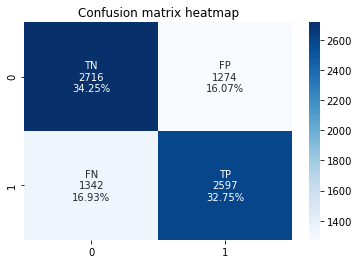

***************************************************************************


In [15]:
run_model(rand_forest)

Iz dobijenih rezultata treniranja modela možemo zaključiti da je RandomForestClassifier najbolji model za predviđanje naših rezultata. U nastavku ćemo iz našeg modela videti koji su fičeri najbitniji (10 najbitnijih) u predviđanju rezultata.

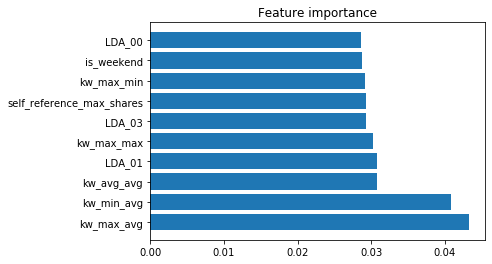

In [16]:
plot_feature_importance(rand_forest)

Odvade možemo zaključiti da su za predviđanje popularnosti online članaka najbitnije ključne reči koje se koriste u nasolvima, srodnost nekim od kategorija LDA_0x (autor dataseta naveo je da su ovo neke kategorije koje su izračunate metodama procesiranja prirodnih jezika) kao i to da li je članak postavljen za vikend.